#### Install utility to download from Google Drive without authentication

Apapted from https://github.com/ICESAT-2HackWeek/topohack/blob/master/notebooks/driveanon_reference_dem_example.ipynb  

Uncomment the following cell and run.

In [1]:
# %%capture
# current_directory = !pwd
# current_directory = current_directory[0]
# %cd ~/
# ! git clone https://github.com/friedrichknuth/driveanon.git
# ! pip install ./driveanon
# %cd {current_directory}

In [2]:
import driveanon

#### Download Lidar DEM over Mt Baker
Uncomment the following cell and run.

In [3]:
# blob_id = '1-8Ca-9_HJL4S7CrX4x5hzH-nrjD4Thpq'
# ! mkdir ~/data
# %cd ~/data
# driveanon.save(blob_id)
# %cd {current_directory}

In [4]:
# ! gdalinfo ~/data/reference_dem_clip.tif

#### Plot DEM

In [5]:
import rasterio
from rasterio.plot import show

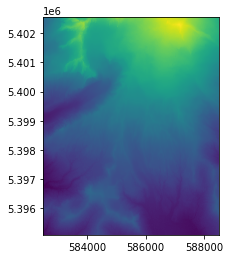

In [6]:
dem_file_name = '/home/jovyan/data/reference_dem_clip.tif'
rasterio_dataset = rasterio.open(dem_file_name)
show(rasterio_dataset);

#### Reproject

In [7]:
# ! gdalwarp -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -dstnodata -9999 -r cubic -t_srs EPSG:4326 {dem_file_name} /home/jovyan/data/reference_dem_clip_4326.tif

In [8]:
# ! gdalinfo /home/jovyan/data/reference_dem_clip_4326.tif

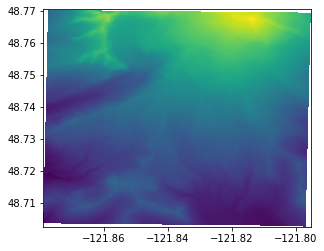

In [9]:
dem_file_name = '/home/jovyan/data/reference_dem_clip_4326.tif'
rasterio_dataset = rasterio.open(dem_file_name)
show(rasterio_dataset);

In [10]:
bounds = list(rasterio_dataset.bounds)

#### Download data using openaltimetry.org API

In [11]:
import requests

In [12]:
base_url = 'https://openaltimetry.org/data/api/icesat2/level3a'

In [13]:
payload =  {'product':'atl06',
            'endDate':'2018-10-19',
            'minx':str(bounds[0]),
            'miny':str(bounds[1]),
            'maxx':str(bounds[2]),
            'maxy':str(bounds[3]),
            'trackId':'326',
#             'beamName':'gt3r',
#             'beamName':'gt3l',
            'beamName':'gt2r',
#             'beamName':'gt2l',
            'outputFormat':'json'}

In [14]:
r = requests.get(base_url, params=payload)
elevation_data = r.json()

#### Extract points and create geodataframe

In [15]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt 
from pyproj import CRS

In [16]:
points = []            
for p in elevation_data['data'][0]['beams'][0]['lat_lon_elev']:
    points.append({
        'lat': p[0],
        'lon': p[1],
        'h': p[2]})

In [17]:
df = pd.DataFrame.from_dict(points)

In [18]:
geometry = [Point(xyz) for xyz in zip(df['lon'], df['lat'], df['h'])]        
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS('EPSG:4326'))

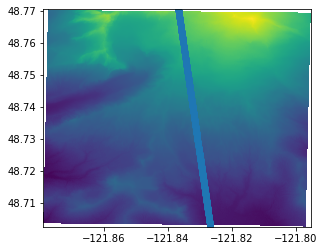

In [19]:
fig,ax = plt.subplots()
show(rasterio_dataset, ax=ax)
gdf.plot(ax=ax);

#### Sample DEM and plot interactively

In [20]:
import hvplot.pandas

In [21]:
laser_hits = list(zip(df['lon'], df['lat']))

In [22]:
dem_elevs = []
for hit in rasterio_dataset.sample(laser_hits):
    dem_elevs.append(hit[0])

In [23]:
comparison_df = list(zip(df['lon'], df['lat'], dem_elevs))     

In [24]:
comparison_df = pd.DataFrame.from_dict({'dem_elev': dem_elevs, 
                                        'is2_elev':df['h']})
comparison_df = comparison_df[comparison_df.dem_elev != rasterio_dataset.nodata]

In [25]:
comparison_df.hvplot.scatter()

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

#### Compute differences

In [26]:
comparison_df['diff'] = comparison_df.dem_elev - comparison_df.is2_elev

In [27]:
merged_df = pd.merge(df, comparison_df, right_index=True, left_index=True)

In [28]:
geometry = [Point(xyz) for xyz in zip(merged_df['lon'], merged_df['lat'], merged_df['diff'])]        
merged_gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs=CRS('EPSG:4326'))

#### Plot

In [29]:
import contextily as ctx

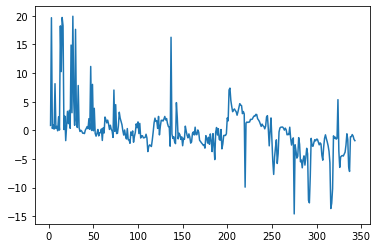

In [30]:
comparison_df['diff'].plot();

In [31]:
merged_gdf = merged_gdf.to_crs(32610)

In [32]:
dem_file_name = '/home/jovyan/data/reference_dem_clip.tif'
src = rasterio.open(dem_file_name)

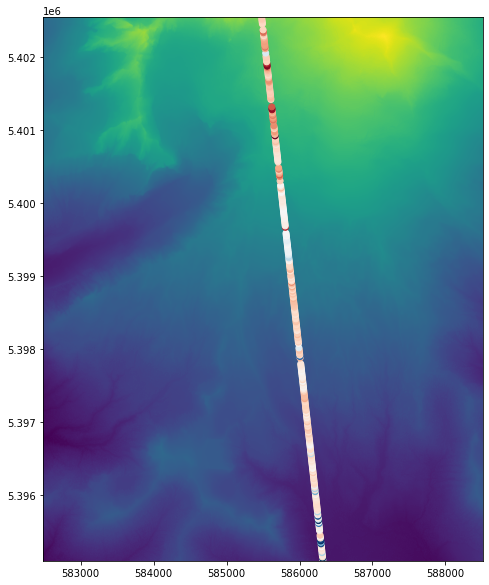

In [33]:
spatial_extent = rasterio.plot.plotting_extent(src)
fig, ax = plt.subplots(1,figsize=(10,10))
ax.imshow(src.read(1, masked=True), extent=spatial_extent, alpha=1)
merged_gdf.plot(column='diff', ax=ax, cmap='RdBu')

In [34]:
url = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'

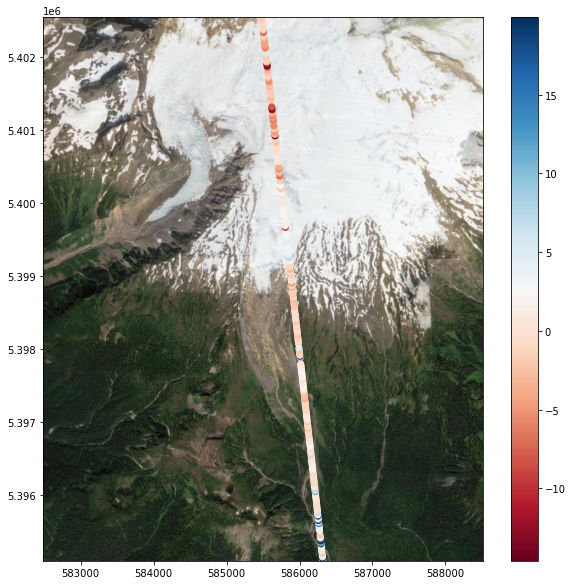

In [35]:
fig, ax = plt.subplots(1,figsize=(10,10))
merged_gdf.plot(column='diff', ax=ax, cmap='RdBu', legend=True)
ax.imshow(src.read(1, masked=True), extent=spatial_extent, alpha=1)
ctx.add_basemap(ax, crs='EPSG:32610', source=url)